In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import logging
import pandas as pd
import subprocess
import mlflow
from mlflow.exceptions import MlflowException
from mlflow.data import from_pandas
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from lime.lime_tabular import LimeTabularExplainer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from src.data_preprocessing import load_or_fetch_view, preprocess_data
from src.balance_data import balance_dataset, save_balanced_data

import warnings
warnings.filterwarnings("ignore")

logging.basicConfig(level=logging.INFO)

In [3]:
logging.info("Starting churn model training pipeline...")

INFO:root:Starting churn model training pipeline...


In [4]:
# File paths
raw_train = "data/raw/vw_ChurnData.csv"
raw_test = "data/raw/vw_JoinData.csv"
proc_train = "data/processed/vw_ChurnData_proc.csv"
bal_train = "data/balanced/vw_ChurnData_bal.csv"
proc_test = "data/test/vw_JoinData_prc.csv"
output_preds = "data/test/Predictions.csv"

# 1) Load raw datasets
train_df = load_or_fetch_view("[db_Churn].[dbo].[vw_ChurnData]", raw_train)
join_df  = load_or_fetch_view("[db_Churn].[dbo].[vw_JoinData]", raw_test)

In [5]:
# 2) Preprocess training data
if os.path.exists(proc_train):
    train_proc = pd.read_csv(proc_train)
else:
    train_proc = preprocess_data(train_df)
    os.makedirs(os.path.dirname(proc_train), exist_ok=True)
    train_proc.to_csv(proc_train, index=False)
    subprocess.run(["dvc", "add", proc_train], check=True)

In [6]:
if os.path.exists(bal_train):
    bal_proc = pd.read_csv(bal_train)
else:
    train_clean = train_proc.dropna(subset=["Customer_Status"])
    if train_clean.empty:
        raise ValueError("No valid rows to balance after preprocessing")
    X, y = train_clean.drop(columns=["Customer_Status"]), train_clean["Customer_Status"]
    Xb, yb = balance_dataset(X, y)
    bal_proc = pd.concat([Xb, yb], axis=1)
    os.makedirs(os.path.dirname(bal_train), exist_ok=True)
    bal_proc.to_csv(bal_train, index=False)
    subprocess.run(["dvc", "add", bal_train], check=True)

In [7]:
# 4) Preprocess test (Join) data
if os.path.exists(proc_test):
    join_proc = pd.read_csv(proc_test)
else:
    join_proc = preprocess_data(join_df)
    join_proc.to_csv(proc_test, index=False)
    subprocess.run(["dvc","add",proc_test], check=True)

In [8]:
# 5) Define models & hyperparameter grid
models = {
    "LogisticRegression": LogisticRegression(),
    "RandomForest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(),
    "KNN": KNeighborsClassifier()
}
param_grid = {
    "LogisticRegression": {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga', 'newton-cholesky']
    },
    "RandomForest": { 'n_estimators': [50, 100], 'max_depth': [None, 10, 20] },
    "XGBoost": { 'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5] },
    "LightGBM": { 'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1], 'num_leaves': [31, 50] },
    "KNN": { 'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance'] }
}

In [9]:
metrics_summary = {'imbalanced': {}, 'balanced': {}}

for label, df, exp_name in [
    ('imbalanced', train_proc, 'Churn_Imbalanced'),
    ('balanced', bal_proc,   'Churn_Balanced')
    ]:
    mlflow.set_experiment(exp_name)
    
    dataset = from_pandas(df, targets='Customer_Status', name=f'vw_Churn_{label}')
    mlflow.log_input(dataset, context='training')

    X = df.drop(columns=['Customer_Status'])
    y = df['Customer_Status']
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # LIME explainer for this label
    explainer = LimeTabularExplainer(
        Xtr.values, feature_names=Xtr.columns.tolist(),
        class_names=['Stayed','Churned'], discretize_continuous=True
    )
    
    for mname, model in models.items():
        if mlflow.active_run():
            mlflow.end_run()
        with mlflow.start_run(run_name = f"{mname}_{label}"):
            grid = GridSearchCV(model, param_grid[mname], scoring='f1', cv=5, n_jobs=-1)
            grid.fit(Xtr, ytr)

            best_model = grid.best_estimator_
            mlflow.log_params(grid.best_params_)

            preds = best_model.predict(Xte)
            p1, r1, f1 = precision_score(yte, preds, pos_label=1), recall_score(yte, preds, pos_label=1), f1_score(yte, preds, pos_label=1)
            p0, r0, f0 = precision_score(yte, preds, pos_label=0), recall_score(yte, preds, pos_label=0), f1_score(yte, preds, pos_label=0)

            mlflow.log_metrics({
                'precision_churned': p1, 'recall_churned': r1, 'f1_churned': f1,
                'precision_stayed': p0, 'recall_stayed': r0, 'f1_stayed': f0
            })
            metrics_summary[label][mname] = {'precision_churned': p1, 'recall_churned': r1, 'f1_churned': f1}

[LightGBM] [Info] Number of positive: 1385, number of negative: 3420
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1346
[LightGBM] [Info] Number of data points in the train set: 4805, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.288241 -> initscore=-0.903940
[LightGBM] [Info] Start training from score -0.903940
[LightGBM] [Info] Number of positive: 3420, number of negative: 3420
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000656 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1458
[LightGBM] [Info] Number of data points in the train set: 6840, number of used features: 28
[LightGBM] [Info] [binar

In [13]:
metrics_summary = {'imbalanced':{}, 'balanced':{}}
lime_summary    = {'imbalanced':{}, 'balanced':{}}
for label, df, exp_name in [
    ('imbalanced', train_proc, 'Churn_Imbalanced'),
    ('balanced', bal_proc,  'Churn_Balanced')
]:

    mlflow.set_experiment(exp_name)

    ds = from_pandas(df, targets='Customer_Status', name=f'vw_Churn_{label}')
    mlflow.log_input(ds, context='training')

    X = df.drop(columns=['Customer_Status'])
    y = df['Customer_Status']
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    explainer = LimeTabularExplainer(
        Xtr.values, feature_names=Xtr.columns.tolist(), class_names=['Stayed','Churned'], discretize_continuous=True
    )

    for mname, model in models.items():
        if mlflow.active_run(): 
            mlflow.end_run()

        with mlflow.start_run(run_name=f"{mname}_{label}"):
            grid = GridSearchCV(model, param_grid[mname], scoring='f1', cv=5, n_jobs=-1)
            grid.fit(Xtr, ytr)
            best = grid.best_estimator_
            
            # ✅ Log the model artifact
            mlflow.sklearn.log_model(best, artifact_path="model")
            mlflow.log_params(grid.best_params_)

            preds = best.predict(Xte)
            p1 = precision_score(yte, preds, pos_label=1)
            r1 = recall_score(yte, preds, pos_label=1)
            f1 = f1_score(yte, preds, pos_label=1)
            p0 = precision_score(yte, preds, pos_label=0)
            r0 = recall_score(yte, preds, pos_label=0)
            f0 = f1_score(yte, preds, pos_label=0)
            
            mlflow.log_metrics({
                'precision_churned': p1, 'recall_churned': r1, 'f1_churned': f1,
                'precision_stayed': p0, 'recall_stayed': r0, 'f1_stayed': f0
            })
            
            metrics_summary[label][mname] = {
                'precision_churned': p1, 'recall_churned': r1, 'f1_churned': f1
            }

            # ✅ LIME explanation
            weights = {feat: [] for feat in Xtr.columns}
            for idx in np.random.choice(Xte.shape[0], size=min(50, Xte.shape[0]), replace=False):
                exp = explainer.explain_instance(Xte.values[idx], best.predict_proba, num_features=len(Xtr.columns))
                for feat, w in exp.as_list(label=1):
                    feat_name = feat.split()[0]
                    if feat_name in weights:
                        weights[feat_name].append(abs(w))
            
            avg_w = {feat: np.mean(ws) for feat, ws in weights.items() if ws}
            top10 = dict(sorted(avg_w.items(), key=lambda x: x[1], reverse=True)[:10])
            lime_summary[label][mname] = top10

2025/05/02 00:13:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/05/02 00:13:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/05/02 00:13:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[LightGBM] [Info] Number of positive: 1385, number of negative: 3420
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1346
[LightGBM] [Info] Number of data points in the train set: 4805, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.288241 -> initscore=-0.903940
[LightGBM] [Info] Start training from score -0.903940


2025/05/02 00:13:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/05/02 00:13:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/05/02 00:14:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/05/02 00:14:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/05/02 00:14:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


[LightGBM] [Info] Number of positive: 3420, number of negative: 3420
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000665 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1458
[LightGBM] [Info] Number of data points in the train set: 6840, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


2025/05/02 00:14:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/05/02 00:15:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


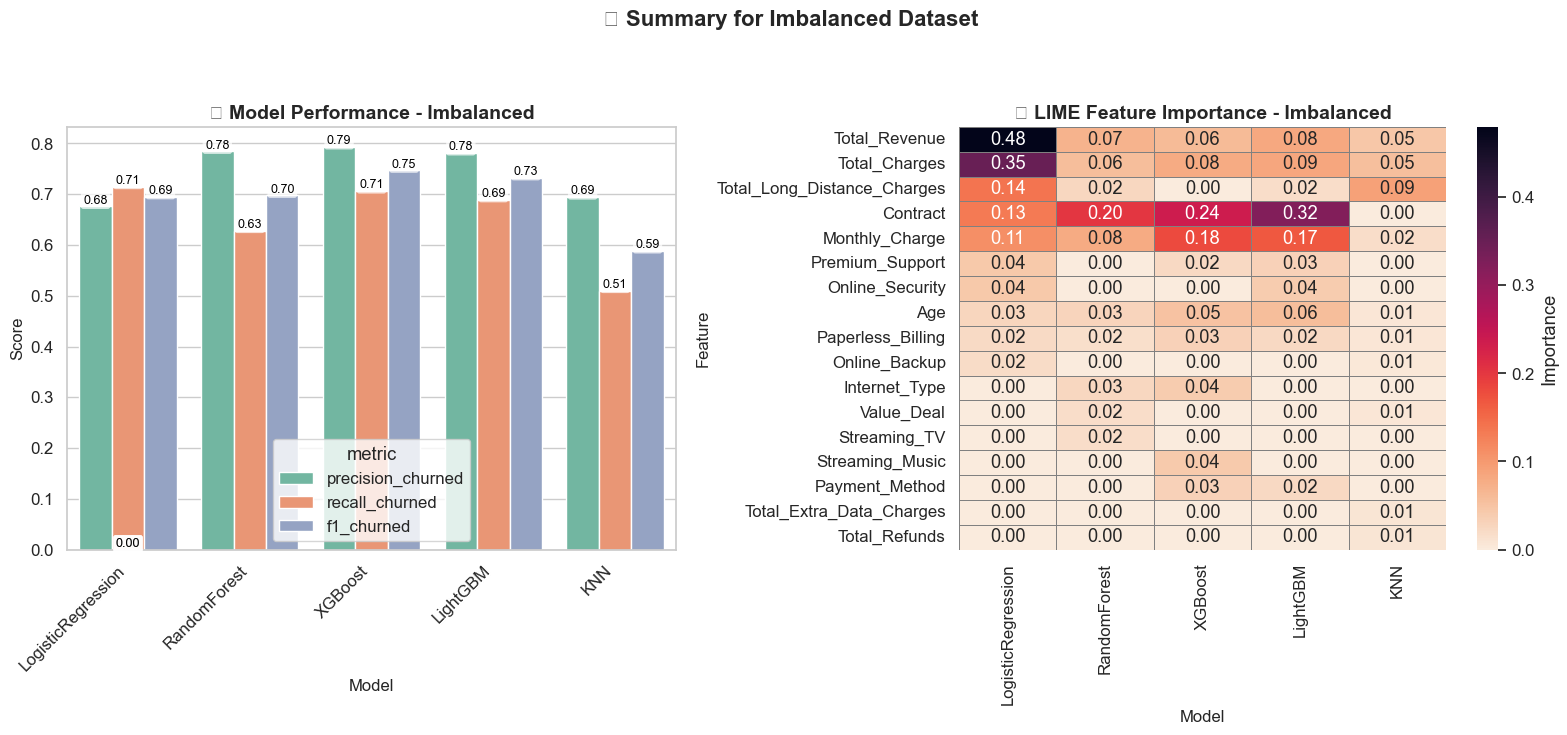

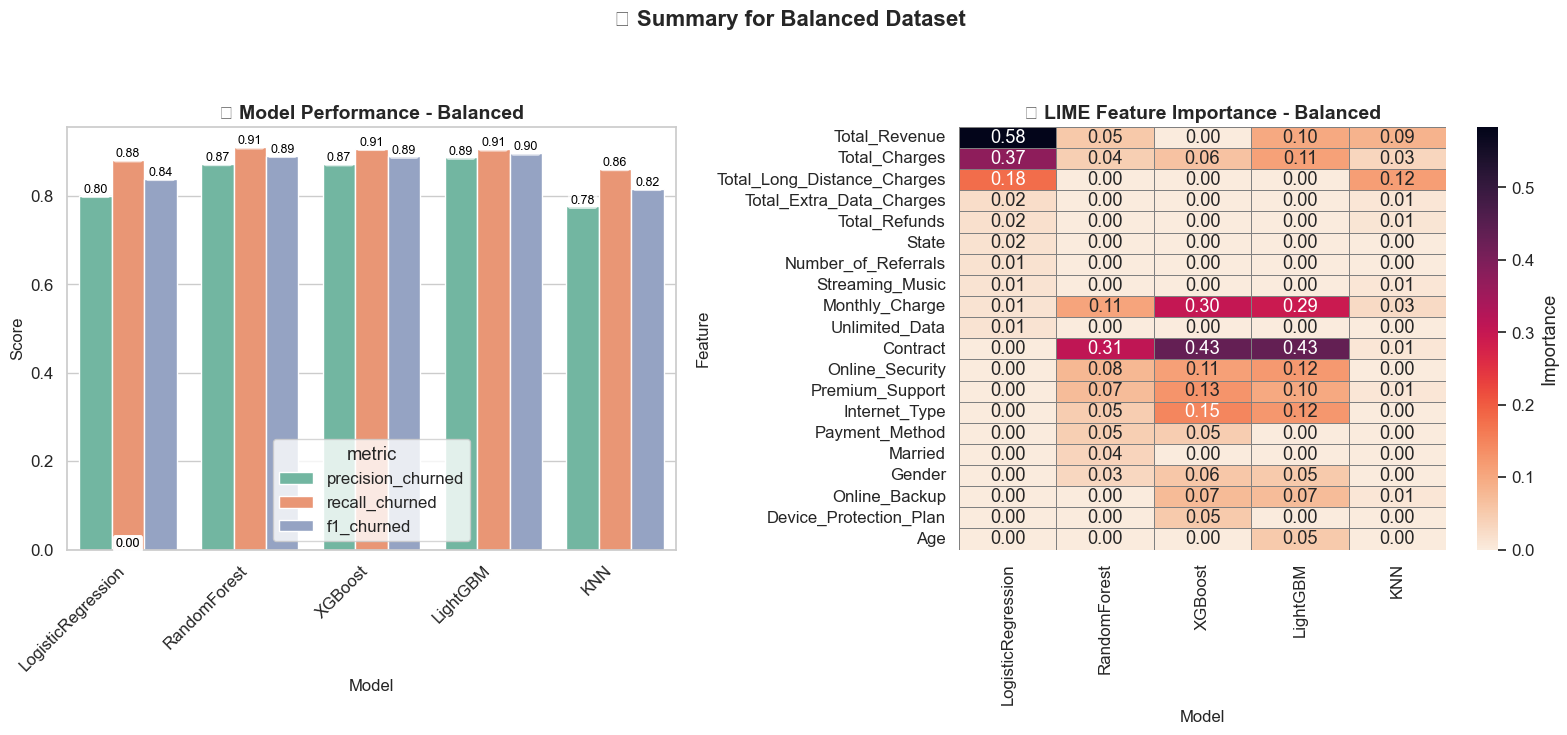

In [11]:
# 7) Plot with seaborn & data labels
sns.set(style='whitegrid', font_scale=1.1)  # prettier theme and slightly bigger font

for label in ['imbalanced', 'balanced']:
    dfm = pd.DataFrame(metrics_summary[label]).T.reset_index().melt('index', var_name='metric')
    limedf = pd.DataFrame(lime_summary[label]).fillna(0)

    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    ax1, ax2 = axes

    # Improved barplot
    palette = sns.color_palette("Set2")
    sns.barplot(data=dfm, x='index', y='value', hue='metric', ax=ax1, palette=palette)
    ax1.set_title(f"📊 Model Performance - {label.capitalize()}", fontsize=14, fontweight='bold')
    ax1.set_ylabel('Score', fontsize=12)
    ax1.set_xlabel('Model', fontsize=12)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

    # Annotate values with better formatting and background
    for p in ax1.patches:
        height = p.get_height()
        if not pd.isna(height):
            ax1.annotate(f"{height:.2f}",
                         (p.get_x() + p.get_width() / 2., height),
                         ha='center', va='bottom',
                         fontsize=9, color='black',
                         bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7))

    # Heatmap with rounded values and updated colormap
    sns.heatmap(limedf, annot=True, fmt='.2f', cmap='rocket_r', ax=ax2,
                cbar_kws={'label': 'Importance'}, linewidths=0.5, linecolor='gray')
    ax2.set_title(f"🧠 LIME Feature Importance - {label.capitalize()}", fontsize=14, fontweight='bold')
    ax2.set_xlabel('Model', fontsize=12)
    ax2.set_ylabel('Feature', fontsize=12)

    # Overall layout
    plt.suptitle(f"🔍 Summary for {label.capitalize()} Dataset", fontsize=16, fontweight='bold', y=1.05)
    plt.tight_layout()
    plt.show()

In [14]:
imb = mlflow.search_runs(experiment_names=['Churn_Imbalanced'], order_by=['metrics.f1_churned DESC'], max_results=1).iloc[0]
bal = mlflow.search_runs(experiment_names=['Churn_Balanced'],  order_by=['metrics.f1_churned DESC'], max_results=1).iloc[0]
best_run = imb if imb['metrics.f1_churned'] >= bal['metrics.f1_churned'] else bal
best_model = mlflow.sklearn.load_model(f"runs:/{best_run.run_id}/model")

In [ ]:
# 8) Select best models from MLflow
imb_run = mlflow.search_runs(experiment_names=['Churn_Imbalanced'], order_by=['metrics.f1_churned DESC'], max_results=1).iloc[0]
bal_run = mlflow.search_runs(experiment_names=['Churn_Balanced'],  order_by=['metrics.f1_churned DESC'], max_results=1).iloc[0]
imb_model = mlflow.sklearn.load_model(f"runs:/{imb_run.run_id}/model")
bal_model = mlflow.sklearn.load_model(f"runs:/{bal_run.run_id}/model")

best_model = imb_model if imb_run['metrics.f1_churned']>=bal_run['metrics.f1_churned'] else bal_model
best_label = 'imbalanced' if imb_run['metrics.f1_churned']>=bal_run['metrics.f1_churned'] else 'balanced'


OSError: No such file or directory: 'D:\github uploads\Customer Churn Prediction & Retention Strategy Using SQL, Power BI & Machine Learning\mlruns\667718995192081604\3586ab27a56b4f82a6e376ab75f7d524\artifacts\model'

In [15]:
# 9) Predict on JoinData and export
Xj = join_proc.drop(columns=['Customer_Status'])
preds = best_model.predict(Xj)
out = join_df.copy()
out['Predicted_Status'] = preds
out.to_csv(output_preds, index=False)
subprocess.run(["dvc","add",output_preds], check=True)
logging.info(f"Exported final predictions to {output_preds}")


INFO:root:Exported final predictions to data/test/Predictions.csv
